In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
import netCDF4 as nc
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplt
from shapely.geometry import Point

In [3]:
file = nc.Dataset("dades/DADES_CALIOPE_buenos/NO2/sconcno2_2023010100.nc")
#sf = shp.Reader("dades/LimitsAdministratius/Catalunya/divisions-administratives-v2r1-catalunya-5000-20240705")
div_gdf = gpd.read_file("dades/LimitsAdministratius/Catalunya/divisions-administratives-v2r1-catalunya-5000-20240705.shp")
lu = rio.open("dades/LandUse/MUCSC_2022_10_m_v_3.tif")

In [23]:
ca_shape = file['sconcno2'].shape
ca_dat = np.reshape(file['sconcno2'], (48, -1))
ca_lon = file['lon']
ca_lat = file['lat']
print(ca_shape)
print(ca_lon.shape)

(48, 1, 298, 278)
(298, 278)


(25949, 26940)


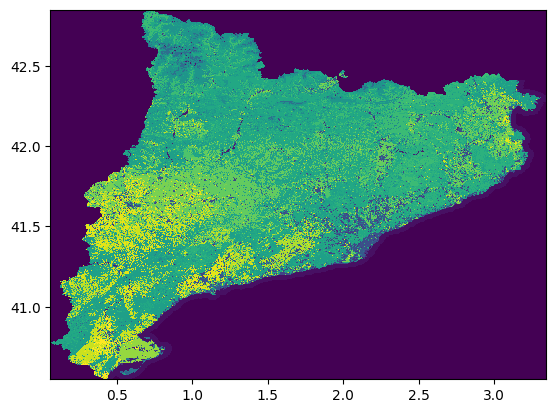

In [45]:
#lu_x = [(lu.transform * (i, 0))[0] for i in range(lu.width)]
lu_x = np.vectorize(lambda x: (lu.transform * (x, 0))[0])(np.arange(max(lu.width, lu.height)))
lu_y = np.vectorize(lambda y: (lu.transform * (0, y))[1])(np.arange(max(lu.height, lu.width)))
lu_gdf = gpd.GeoDataFrame(
    {'geometry': [Point(lon, lat) for lon, lat in zip(lu_x, lu_y)]},
    crs="EPSG:25831"
)
lu_gdf = lu_gdf.to_crs(4326)
lu_lon = lu_gdf.geometry.x.to_numpy()
lu_lat = lu_gdf.geometry.y.to_numpy()
lu_lon = lu_lon[:lu.width]
lu_lat = lu_lat[:lu.height]
lu_dat = lu.read(1)
print(lu_dat.shape)
plt.pcolormesh(lu_lon[:lu.width:50], lu_lat[:lu.height:50], lu_dat[::50, ::50])
plt.show()

In [46]:
lu_ponderacions = np.ones(26)
# INFRAESTRUCTURES VIARIES
lu_ponderacions[4] = 1.2
# URBANITZACIONS
lu_ponderacions[5] = 1.1
# ZONES URBANES
lu_ponderacions[6] = 1.2
# ZONES INDUSTRIALS I COMERCIALS
lu_ponderacions[7] = 1.3
print(lu_ponderacions)

[1.  1.  1.  1.  1.2 1.1 1.2 1.3 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1. ]


In [ ]:
ca_tree = spatial.KDTree(np.vstack((np.ravel(ca_lon), np.ravel(ca_lat))).T)

In [53]:
def find_nearest(array, value):
    return (np.abs(array - value)).argmin()
def find_nearestv(array, valuev):
    #n = array.size
    #return (np.abs(array - np.reshape(np.repeat(valuev,n),(-1,n)))).argmin(axis=1)
    return [
        find_nearest(array, value)
        for value in np.nditer(valuev)
    ]
def find_nearestp(lons, lats, lon, lat):
    pass
def predict(lon, lat, data):
    lu_lon_i = find_nearest(lu_lon, lon)
    lu_lat_i = find_nearest(lu_lat, lat)
    return data*lu_ponderacions[lu_dat[lu_lat_i][lu_lon_i]]
def predictv(lonv, latv, time):
    lu_lon_iv = find_nearestv(lu_lon, lonv)
    lu_lat_iv = find_nearestv(lu_lat, latv)
    ca_indexs = ca_tree.query(np.vstack((np.ravel(lonv), np.ravel(latv))).T)[1]
    return ca_dat[time][ca_indexs] * lu_ponderacions[lu_dat[lu_lat_iv, lu_lon_iv]]
    
predictv(2.5,30,0)-ca_dat[0][0]

array([0.00155433])

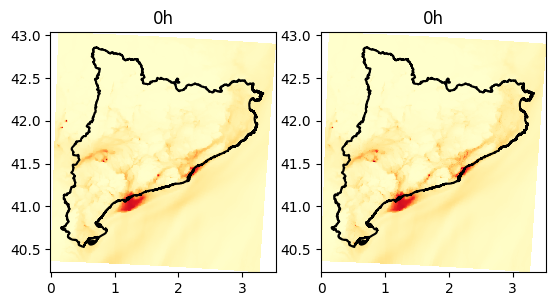

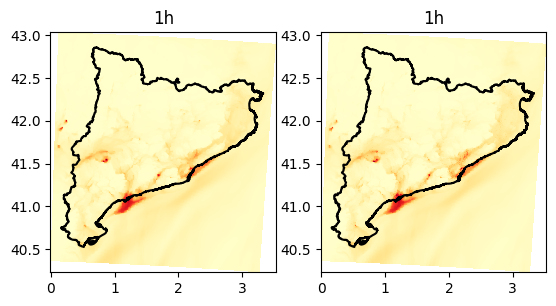

KeyboardInterrupt: 

In [54]:
lon = file['lon']
lat = file['lat']
for h, dat in enumerate(ca_dat[0:24]):
    fig, ax = plt.subplots(1, 2)
    pred_dat = predictv(ca_lon, ca_lat, h)
    _max = max(np.max(dat), np.max(pred_data))
    ax[0].pcolormesh(lon, lat, np.reshape(dat, ca_shape[2:]), cmap='YlOrRd', vmin=0, vmax=_max)
    ax[1].pcolormesh(ca_lon, ca_lat, np.reshape(pred_dat, ca_shape[2:]), cmap='YlOrRd', vmin=0, vmax=_max)
    for axi in ax:
        axi.set_title(f"{h % 24}h")
        div_gdf.to_crs(4326).boundary.plot(ax=axi, color='k')
    plt.show()